In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataCollection import *

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
OC = 'NGC_2682'

In [3]:
#step0: match apogee data with gaia data
apogee_Teff = matchApogeeGaia(OC)

#step 1: get members in gaia IDs and write a simbad input file
gaia_IDs, member_df = genSimbad(OC, "{}/{}_simbad_input.txt".format(OC,OC))

#step 2: astroquery for gaia Gband mags, luminosities and distances
gaia_df = GAIA_query(gaia_IDs)

#step 3: merging apogee_gaia df with gaia_df
step3_df = mergeApogee(gaia_df, apogee_Teff)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  


Found 328589 matching APOGEE and GAIA stars.
2609 of those stars have Teff data.
There is 1502 stars in the membership paper.
Simbad input txt file saved as "NGC_2682/NGC_2682_simbad_input.txt".
Launching GAIA query...


Obtained 1502 out of 1502 stars in the cluster.
Matching APOGEE Teffs to queried GAIA stars
Found 29 matching stars with APOGEE Teff data.


In [4]:
#step 4: read simbad output file and combine it to step3_df
step4_df = readSimbad(f'{OC}/{OC}_simbad_output.txt',step3_df)

#step 5: matching back in ra, dec and membership prob from membership paper, and apply membership cut for total membership>99%
step5_df = membershipCut(step4_df, member_df)

#step 6: Teff selection: 1.apogee, 2.singulars, 3.take away problematics, 
# 4.apply most widespread source of Teff until all multiples have Teff, 5.manual picking of problematics
assigned_df, problematic_df, final_ranks = assignTeff(step5_df)
final_ranks

Reading SIMBAD output and merging it to GAIA+APOGEE data...
found 1502 matching IDs
155 stars have Teff data
Found Teff for 163 stars between SIMBAD and APOGEE.
Matching in membership data and applying membership cut...
163/163 stars are taken as cluster members
Using APOGEE Teff for 29 stars.
There are 51 stars without APOGEE data and have Teff provided by only one paper.
Picking Teff automatically for 73 stars, 10 stars require manual picking.


C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Teff'][i] = paper[0]
C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ref'][i] = paper[2]


,ref,count
0,2011AJ....141...89S,68.0
1,2013AJ....146..134K,15.0
2,2016A&A...589A.115S,15.0
3,2011AJ....142...59J,8.0
4,2009A&A...493..309S,5.0
5,2000AJ....120.1913S,4.0
6,2006A&A...450..557R,4.0
7,2012A&A...538A.143K,2.0
8,2016ApJ...823..114N,1.0
9,2018MNRAS.480.4314B,1.0


In [9]:
def replaceManual(df, ranks):
    count=0
    for i,star in df.iterrows():
        count+=1
        print('Star {}/{}, GAIA ID: {}'.format(count,len(df.index),star['ID']))
        Teff = []
        ref = []
        for entry in star['feh_table']:
            Teff.append(entry[0])
            ref.append(entry[2])
        median = np.median(Teff)
        diff = np.array(Teff)-median
        for j,entry in enumerate(star['feh_table']):
            ref_df = ranks[ranks['ref']==ref[j]]
            if len(ref_df.index)==0:
                entry_no = 0
            else:
                entry_no = int(ref_df['count'])
            if diff[j]>90:
                print('\033[1m'+str(j)+': '+str(Teff[j])+' '+ref[j]+' '+str(entry_no)+' entries'+'\033[0m')
            else:
                print(str(j)+': '+str(Teff[j])+' '+ref[j]+' '+str(entry_no)+' entries')
        decision_index = int(input('Teff choice?'))
        df['Teff'][i] = Teff[decision_index]
        df['ref'][i] = ref[decision_index]
        print()
    return df

#manual assigning of problematic Teffs
problematic_df = replaceManual(problematic_df, final_ranks)
step6_df = pd.concat([assigned_df,problematic_df])
step6_df.sort_index(inplace=True)

Star 1/10, GAIA ID: 604910860486613632
0: 6508.0 2013AJ....146..134K 15 entries
1: 5741.0 2011AJ....141...89S 68 entries
2: 5825.0 2008AJ....136.2050L 0 entries
Teff choice?1


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Star 2/10, GAIA ID: 604911337227185920
0: 5963.0 2018MNRAS.480.4314B 1 entries
1: 6170.0 2000AJ....120.1913S 4 entries
Teff choice?1

Star 3/10, GAIA ID: 604911375882674560
0: 4250.0 2000A&A...360..499T 0 entries
1: 4200.0 2005AJ....130..597Y 0 entries
2: 4353.0 2013AJ....146..134K 15 entries
3: 4200.0 2011AJ....142...59J 8 entries
4: 4186.0 2011A&A...531A.165P 0 entries
Teff choice?4

Star 4/10, GAIA ID: 604914949295282816
0: 5970.0 2018A&A...620A..58S 1 entries
1: 5759.0 2016A&A...589A.115S 15 entries
2: 5780.0 2014A&A...562A.102O 0 entries
3: 5810.0 2011AJ....141...89S 68 entries
4: 5884.0 2008AJ....136.2050L 0 entries
Teff choice?3

Star 5/10, GAIA ID: 604917285757662592
0: 6151.0 2006A&A...450..557R 4 entries
1: 5846.0 2013AJ....146..134K 15 entries
Teff choice?1

Star 6/10, GAIA ID: 604917487620349184
0: 6223.0 2006A&A...450..557R 4 entries
1: 5729.0 2013AJ....146..134K 15 entries
Teff choice?1

Star 7/10, GAIA ID: 604917594995372544
0: 4450.0 2000A&A...360..499T 0 entries
1: 44

In [10]:
#listing all papers to google
countUniqueRefs(step6_df, column='ref')

,ref,count
0,2011AJ....141...89S,71.0
1,apogee,29.0
2,2013AJ....146..134K,17.0
3,2016A&A...589A.115S,15.0
4,2011AJ....142...59J,9.0
5,2000AJ....120.1913S,5.0
6,2009A&A...493..309S,5.0
7,2006A&A...450..557R,4.0
8,2016ApJ...823..114N,3.0
9,2012A&A...538A.143K,2.0


In [11]:
#Matching Teff errors from papers:
resulting_df = matchTeff_err(step6_df, '2011AJ....141...89S', OC+'/2011AJ....141...89S_Teff.txt',2,3,6,7)
resulting_df = matchTeff_err(resulting_df, '2013AJ....146..134K', OC+'/2013AJ....146..134K_Teff.txt', 4,5,1,2)
resulting_df = matchTeff_err(resulting_df, '2016A&A...589A.115S', OC+'/2016AA_589A_115S_Teff.txt', 0,1,2,3)
resulting_df = fixedTeff_err(resulting_df, '2011AJ....142...59J', 200)
resulting_df = fixedTeff_err(resulting_df, '2006A&A...450..557R', 70)
resulting_df = fixedTeff_err(resulting_df, '2000AJ....120.1913S', 200)
#dropping this one paper's one star due to unable to find any clue to its Teff error and it is quite "outside" of the main M67 isochrone
resulting_df.drop(index=resulting_df[resulting_df['ref']=='2018MNRAS.480.4314B'].index, inplace=True)
resulting_df = matchTeff_err(resulting_df, '2012A&A...538A.143K', OC+'/2012AA...538A.143K_Teff.txt', None,None,1,2)
resulting_df = fixedTeff_err(resulting_df, '2016ApJ...823..114N', 200)
resulting_df = matchTeff_err(resulting_df, '2009A&A...493..309S', OC+'/2009AA...493..309S_Teff.txt', None,None,1,2)
#last paper only supplies one star and the star is a RGB that will be removed, so putting in 200K as placeholder
resulting_df = fixedTeff_err(resulting_df, '2011A&A...531A.165P', 200)
step7_df = matchTeff_err(resulting_df, '2018A&A...620A..58S', OC+'/2018AA...620A..58S_Teff.txt', None,None,0,1)

C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Teff_err'][i]=Teff_err[j]
C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Teff_err'][i] = list(suspect_df['Teff_err'])[np.argmin(angular_dist)]
C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:473: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Teff_err'][i]=Teff_err


In [12]:
dist = step7_df['distance']
dist = dist[np.logical_not(np.isnan(dist))]
dist_err = step7_df['distance_err']
dist_err = dist_err[np.logical_not(np.isnan(dist_err))]
mean_dist = np.sum(dist*dist_err**(-2))/np.sum(dist_err**(-2))
mean_dist_err = np.sqrt(1/np.sum(dist_err**(-2)))
print(mean_dist_err)
luminosity, luminosity_err = lum_calc(OC, step7_df['g_mag'], step7_df['g_mag_err'], mean_dist, mean_dist_err, list(step7_df['Teff']), list(step7_df['Teff_err']))
step8_df = step7_df.copy()
step8_df['cal_lum'] = luminosity
step8_df['cal_lum_err'] = luminosity_err
step8_df.dropna(subset=['cal_lum'],inplace=True)

2.1311586016217907
Invalid temperature 8947.0. BC has been set to Nan


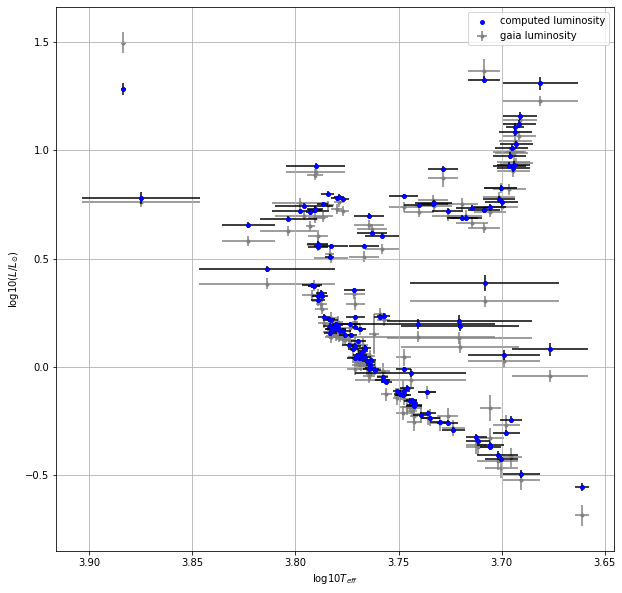

In [15]:
#apply cut that removes RGB stars
step8_df['value'] = 10*np.log10(step8_df['Teff'])-np.log10(step8_df['cal_lum'])-35.5
cut_df = step8_df[step8_df['value']>0].copy()

#plotting cluster to count number of blue stragglers, and other stars to remove
plotCluster(cut_df, plot_gaia=True)

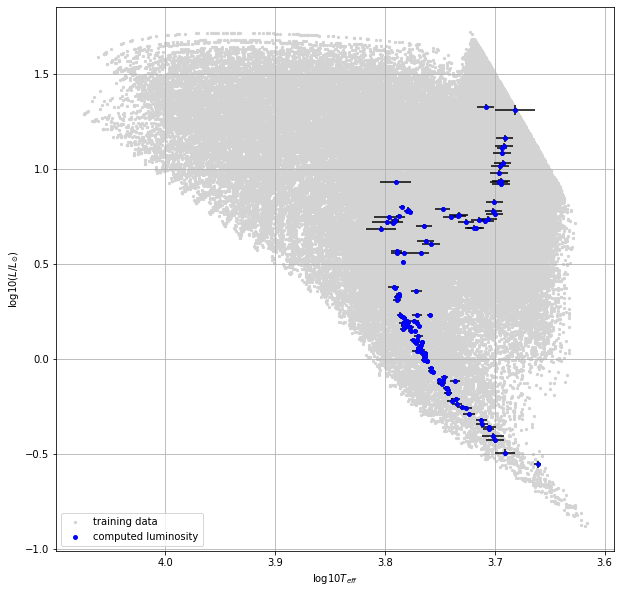

In [17]:
#removing blue stragglers
high_Teff_IDs = np.array(cut_df['ID'])[np.argsort(cut_df['Teff'])[-4:]]
step9_df = cut_df.drop(index=step8_df[step8_df['ID'].isin(high_Teff_IDs)].index)

#removing other weird stars
step9_df = removeStars(step9_df, 3.7, 0.25,4)
step9_df = removeStars(step9_df, 3.69, 0.125,2)
step9_df = removeStars(step9_df, 3.695, -0.25,2)
step9_df = removeStars(step9_df, 3.73, 1,1)
step9_df = removeStars(step9_df, 3.748, 0,2)
step9_df = removeStars(step9_df, 3.76, 0.25,1)

plotCluster(step9_df, plot_gaia=False, plot_train=True, grid_path='grid2_early.csv')

In [84]:
#save data to csv
step9_df.to_csv(f'{OC}/{OC}_final.csv',index=False)